<a href="https://colab.research.google.com/github/2000siddharth/web_scraping_classification/blob/master/neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.utils import np_utils 
from keras.initializers import RandomNormal
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
df = pd.read_csv('combined_youtube4.csv')

In [0]:
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [0]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
len(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [0]:
cleaned_title = []

for sentance in tqdm(df['title'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())

100%|██████████| 10275/10275 [00:02<00:00, 4289.01it/s]


In [0]:
df['title'] = cleaned_title

In [0]:
X = df['title']
y = df['category']

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_test = X[train_index], X[test_index]
    y_Train, y_test = y[train_index], y[test_index] 

from sklearn.model_selection import train_test_split
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, random_state=0, stratify=y_Train, test_size=0.1)

In [0]:
y_train = array(y_train)

In [0]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(y_train)

['tutorial' 'tutorial' 'history' ... 'fashion' 'history' 'music']


In [0]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
y_train = onehot_encoded

In [0]:
y_test = array(y_test)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test)
print(y_test)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

['movies' 'art' 'fashion' ... 'vlog' 'science' 'art']
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [0]:
y_test = onehot_encoded

In [0]:
tf_idf=TfidfVectorizer(ngram_range=(1,2))

tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
Test_TFIDF= tf_idf.transform(X_test)

In [0]:
X_train = preprocessing.normalize(Train_TFIDF)
X_test = preprocessing.normalize(Test_TFIDF)

In [0]:
output_dim = 10
input_dim = X_train.shape[1]
batch_size = 64 
nb_epoch = 20

In [0]:
model_Relu = Sequential()
model_Relu.add(Dense(512, activation='relu', input_dim=input_dim , kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model_Relu.add(Dense(128, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model_Relu.add(Dense(output_dim, activation='softmax'))
model_Relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history= model_Relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))
model_Relu.summary()

In [0]:
accr = model_Relu.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2055/2055 [==============================] - 3s 1ms/step
Test set
  Loss: 0.539
  Accuracy: 0.876


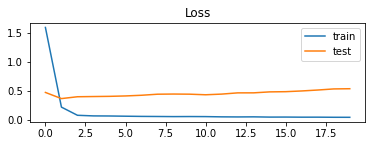

In [0]:
import matplotlib.pyplot as plt

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

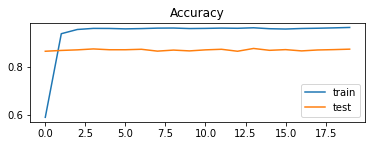

In [0]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
yhat_classes = model_Relu.predict_classes(X_test, verbose=0)

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(integer_encoded, yhat_classes)

In [0]:
c = df['category'].unique()

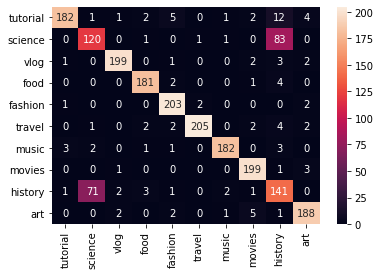

In [0]:
Train_cm = pd.DataFrame(matrix,index = c,columns = c)
sns.heatmap(Train_cm, annot=True,fmt="d")